# CS4220 Project 2 - Pathogen Detection

In this notebook, we give an example to show how to read and use the DNA read data. We will train one base line model, using `sklearn.LogisticRegression`, and use it to predict the pathogens in each patient's dataset.

## Related python packages

To get started (if you are using python), you may want to create a virtual python environment and install some packages. Here are some of the commands you might need:

```bash
conda create --name cs4220 python=3.8

# Install jupyter notebook if you are using it
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=cs4220
conda install -c anaconda jupyter

# Some common packages
conda install pandas                      # for reading csv
conda install scikit-learn                # for the logistic regression model
pip install pytorch                       # if you are using neural networks
conda install -c conda-forge matplotlib   # for plotting
conda install seaborn                     # also for plotting
pip install umap-learn[plot]              # plotting UMAP plots
conda install numpy                       # for many math/vectorized operations
```

In [1]:
# import packages

import numpy as np
import pandas as pd
import timeit
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from umap.umap_ import UMAP
from joblib import dump, load
from itertools import chain
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from typing import Union, Any
import statistics 

from utils.common import *
from utils.dataset import CS4220Dataset
from utils.feature_selection import random_forest_selector
from utils.model_evaluation import _read_model, get_all_jaccard_index, performance_evaluate, get_all_jaccard_index_with_transformation

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import colorcet
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

import umap.plot
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [35]:
# Check the current working directory
%pwd

'/Users/melloo21/Desktop/NUS Items/CS4220/cs4220_project_2/cs4220-pathogen-detection'

## Testing Utils

In [28]:
from sklearn.ensemble import RandomForestRegressor

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def random_forest_selector(X,y):
    # Using feature importance to select features
    model = RandomForestRegressor(random_state=1, max_depth=10)
    model.fit(X,y)
    features = X.columns
    importances = model.feature_importances_
    # Create a dataframe for feature importance
    feature_importance_df = pd.DataFrame({"features": list(features) ,"importances": list(importances)} )
    indices = np.argsort(importances)[-9:]  # top 10 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

    return feature_importance_df

def create_coarse_labels(df):
    df['coarse_species_name'] = np.where(df['species_name'] != "decoy", "non_decoy", "decoy")
    le = preprocessing.LabelEncoder()
    le.fit(df['coarse_species_name'].unique())
    y_index = le.transform(df['coarse_species_name'].values)
    df['labels'] = y_index
    print(f"Unique labels {len(df['coarse_species_name'].unique())}")
    return df, le

def jaccard_index_per_patient(patient_id:str, preds):
    # Generic filename
    df_true = pd.read_csv('test_data/patient{}_labels.csv'.format(patient_id))
    tp, fp, tp_fn = 0, 0, df_true['labels'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['labels'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['labels'].values:
            tp += 1
        else:
            fp += 1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp / (tp_fn + fp) , preds, df_true['labels'].values

def get_all_jaccard_index_with_transformation( model:Any, label_encoder:Any , x_transformer:Any, num_patients:int=10, threshold:float=0.95):

    all_jaccard_index = []
    all_pred = []
    all_true = []
    for patient_id in range(num_patients):
        print('predicting for patient {}'.format(patient_id))

        with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
            df_test = np.load(read_file)

        # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
        transformed_data =x_transformer.fit_transform(df_test)
        y_pred = model.predict(transformed_data)

        # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
        # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
        y_predprob = model.predict_proba(transformed_data)

        # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
        final_predictions = label_encoder.inverse_transform(
                                np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                            ))
        
        # my pathogens dectected, decoy will be ignored
        final_predictions = [item for item in final_predictions if item !='decoy']

        print(f"final_predictions {final_predictions} , unique {np.unique(final_predictions)}")
        ji, pred_pathogen, true_pathogen = jaccard_index_per_patient(patient_id, final_predictions)
        print('Jaccard index: {}'.format(ji))
        all_jaccard_index.append(ji)    
        all_pred.append(pred_pathogen)
        all_true.append(true_pathogen)

    return all_jaccard_index, flatten(all_pred), flatten(all_true)

def flatten(original_list:list):
    return list(chain.from_iterable(original_list))

def get_kmer_analysis_map(dataset):
    test = dataset.X_mapped.copy()
    test["labels"] = dataset.Y   
    return test.groupby("labels").mean().reset_index()
    
def getting_no_kmer_existence(analysis):

    kmer_by_label = dict()
    # Obtaining the profile
    for elem in analysis.index:
        kmer_by_label[elem] = analysis.iloc[elem,1:-1]

    # Getting label without that kmer
    for elem in analysis.index:
        kmer_zero = list(kmer_by_label[elem][kmer_by_label[elem]==0].index)
        if (len(kmer_zero) > 0):
            print(f" label {elem} ::  {kmer_zero}")

    return kmer_zero

def get_label_by_kmer(kmer_analysis):
    label_profile_by_kmer = dict()

    # Obtaining the profile
    for elem in range(1,len(kmer_analysis.columns)-1):
        label_profile_by_kmer[kmer_analysis.columns[elem]] = kmer_analysis.iloc[:,elem]
    return label_profile_by_kmer

def get_std_across_labels_by_kmer(kmer_analysis):
    label_profile_by_kmer = get_label_by_kmer(kmer_analysis)

    std_accross_labels = dict()

    for key, values in label_profile_by_kmer.items():
        std_accross_labels[key] = np.std(values)

    # Sort by variation
    std_accross_labels_sorted = dict(sorted(std_accross_labels.items(), key=lambda item: item[1]))

    return std_accross_labels_sorted

## Parsing Input Data

First, some dataset statistics. We load our training labels (ground truth) and see how many reads a category (species) have.

In [8]:
label_df = pd.read_csv('./training_data/train_labels.csv')
get_species_count(label_df)

(461581,
 species_name
 decoy                              413476
 burkholderia_pseudomallei            3533
 pseudomonas_aeruginosa               3126
 klebsiella_michiganensis             2989
 mycobacterium_ulcerans               2910
 klebsiella_pneumoniae                2806
 serratia_liquefaciens                2629
 vibrio_parahaemolyticus              2579
 salmonella_enterica_typhimurium      2507
 yersinia_enterocolitica              2276
 stenotrophomonas_maltophilia         2217
 mycobacterium_tuberculosis           2175
 clostridioides_difficile             2007
 acinetobacter_baumannii              1964
 legionella_pneumophila               1753
 listeria_monocytogenes               1479
 staphylococcus_aureus                1384
 staphylococcus_pseudintermedius      1328
 corynebacterium_ulcerans             1266
 corynebacterium_diphtheriae          1194
 streptococcus_suis                   1092
 neisseria_gonorrhoeae                1087
 streptococcus_agalactiae      

In [9]:
# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (26 classes - pathogens and decoy)
processed_label_df ,label_encoder = create_label_df(label_df)
#this label_df will have label index instead of the actual class value

Unique labels 26


In [10]:
#500 here means that there are at most 500 per label class
# find ways to reduce the sample size as there are >10000 samples

samples_500_index = create_sampling_idx(label_df,500)
display(samples_500_index)

Index([  594,    56,  1899,  1101,  1152,   870,  1727,  1465,  1642,   234,
       ...
       45999, 46477, 46850, 47680, 46695, 46102, 46340, 47424, 46009, 47245],
      dtype='int64', length=13000)

In [11]:
# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df, samples_index=samples_500_index)
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(sampled_dataset.Y))

13000 2080
13000


In [12]:
# Using all data
all_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df)
print(len(all_dataset.X[:, :-1]), len(all_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(all_dataset.Y))

461581 2080
461581


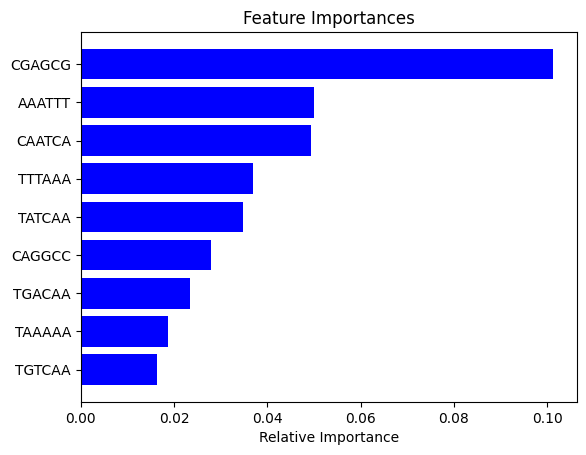

In [13]:
feature_importance_df = random_forest_selector(X=sampled_dataset.X_mapped, y=sampled_dataset.Y)

In [30]:
print_full(feature_importance_df.sort_values(by="importances"))

     features   importances
616    AGGCCT  1.759256e-07
617    AGGCGA  4.949453e-07
1842   GGGGGA  1.074521e-06
2027   TCGAGA  1.144097e-06
634    AGGGTC  1.522039e-06
1384   CGTAGC  1.887020e-06
407    ACGGGA  2.032958e-06
737    ATAGGG  3.102705e-06
1210   CCGTAC  3.318752e-06
1166   CCCGTC  3.428146e-06
637    AGGTAC  3.745857e-06
1767   GCTCTA  3.772217e-06
686    AGTGTA  4.279168e-06
681    AGTGCC  4.302435e-06
671    AGTCGC  4.331594e-06
562    AGCCGA  4.712160e-06
1852   GGTACC  5.314645e-06
290    ACAGGG  5.321972e-06
863    ATTAGC  5.893337e-06
1851   GGTACA  6.109700e-06
1838   GGGCTA  6.332323e-06
1971   TACGTA  6.881625e-06
322    ACCATA  6.907767e-06
517    AGAGCC  6.979859e-06
1376   CGGTTC  7.444109e-06
520    AGAGGA  7.568097e-06
386    ACGCAG  7.818835e-06
1282   CGAGAG  7.823757e-06
1110   CCACTA  8.006757e-06
433    ACTACG  8.246880e-06
1017   CAGCGA  8.541353e-06
658    AGTAGC  8.553680e-06
1799   GGATAC  9.537875e-06
695    AGTTCG  9.617615e-06
1694   GCAGTA  9.704

In [32]:
std_accross_labels_sorted

{'CCTAGG': 5.1387982e-05,
 'CCCCTA': 5.507246e-05,
 'GCCCTA': 5.5780525e-05,
 'AGGTTC': 5.8115173e-05,
 'CCCTAC': 5.8322734e-05,
 'CACTAC': 5.9068967e-05,
 'GTATAC': 5.9397356e-05,
 'GAATTC': 6.0622107e-05,
 'TACGTA': 6.088091e-05,
 'CTACAC': 6.253549e-05,
 'AGGTAC': 6.2763895e-05,
 'AGTACT': 6.5407796e-05,
 'ATGGAC': 6.5610715e-05,
 'CGTCTA': 6.639613e-05,
 'ACCCTA': 6.657607e-05,
 'GCTAGC': 6.726471e-05,
 'CCCCCC': 6.743723e-05,
 'AGATCT': 6.7732006e-05,
 'GTACAC': 6.8141075e-05,
 'ACTACC': 6.8364185e-05,
 'GAGTAC': 6.842283e-05,
 'TGTACA': 6.8523346e-05,
 'ACCCCT': 6.875428e-05,
 'ACTAGT': 6.944566e-05,
 'GGACTA': 7.048328e-05,
 'AGATGC': 7.071306e-05,
 'ATAGGG': 7.0792674e-05,
 'ACCTAC': 7.09052e-05,
 'GTAGAC': 7.1309565e-05,
 'GACCTA': 7.167955e-05,
 'AGTACC': 7.178304e-05,
 'CCCTAG': 7.206969e-05,
 'CTTAAG': 7.285511e-05,
 'GGTAGA': 7.506491e-05,
 'AAGGGT': 7.557646e-05,
 'AGGGAC': 7.61835e-05,
 'AGAACC': 7.62666e-05,
 'AGGGGG': 7.668653e-05,
 'TTCGAA': 7.6937315e-05,
 'GGTTCA': 

In [14]:
feature_importance_df.to_csv("feature_impt.csv")

(array([ 32.,  81., 136., 177., 208., 186., 171., 131.,  96.,  97.,  64.,
         71.,  61.,  47.,  69.,  39.,  44.,  29.,  30.,  25.,  29.,  18.,
         14.,  18.,  14.,  17.,  14.,   8.,   7.,   7.,  12.,   6.,  10.,
          8.,   8.,  11.,   7.,   6.,   2.,   8.,   3.,   4.,   4.,   5.,
          4.,   3.,   1.,   5.,   3.,   1.,   1.,   1.,   2.,   0.,   1.,
          1.,   1.,   2.,   1.,   2.,   0.,   1.,   0.,   0.,   1.,   1.,
          0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,
          1.,   1.,   2.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([5.16676810e-05, 7.35344001e-05, 9.54011193e-05, 1.17267839e-04,
        1.39134558e-04, 1.61001270e-04, 1.82867996e-04, 2.04734708e-04,
        2.26601434e-04, 2.48468132e-04, 2.70334858e-04, 2.92201585e-04,
        3.14068311e-04, 3.35935008e-04, 3.57801735e-04, 3.79668461e-04,
        4.01535188e-04, 4.2340

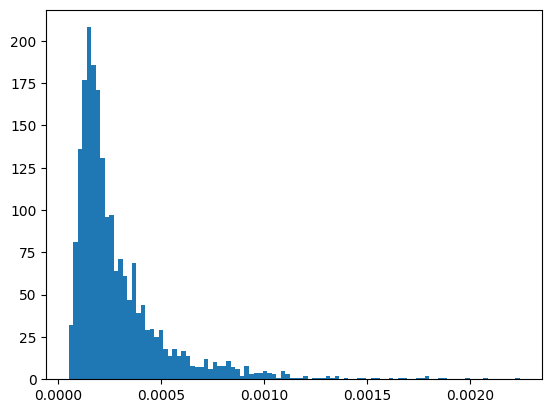

In [118]:
plt.hist(std_accross_labels_sorted.values(),bins=100)

In [86]:
len([elem for elem in std_accross_labels_sorted.values() if elem <  0.0001 ])

139

In [18]:
kmer_analysis = get_kmer_analysis_map(all_dataset)

# For entire dataset
getting_no_kmer_existence(kmer_analysis)
std_accross_labels_sorted = get_std_across_labels_by_kmer(kmer_analysis)
all_dataset_features_to_drop = [key for key, elem in std_accross_labels_sorted.items() if elem <  0.0001 ]

 label 3 ::  ['CGATCG']


In [100]:
# For sampled dataset

kmer_analysis = get_kmer_analysis_map(sampled_dataset)

getting_no_kmer_existence(kmer_analysis)

get_std_across_labels_by_kmer(kmer_analysis)

sampled_features_to_drop = [key for key, elem in std_accross_labels_sorted.items() if elem <  0.0001 ]

 label 3 ::  ['CGATCG', 'CGCGCG']


In [111]:
std_accross_labels_sorted["AAATTT"]

0.0009589204

In [105]:
sampled_features_to_drop

['CCTAGG',
 'CCCTAC',
 'CCCCTA',
 'AGGTTC',
 'GCCCTA',
 'CACTAC',
 'TACGTA',
 'GAATTC',
 'GTATAC',
 'AGGTAC',
 'GCTAGC',
 'CCCCCC',
 'CTACAC',
 'ACTAGT',
 'AGTACT',
 'CGTCTA',
 'GTACAC',
 'TGTACA',
 'ACCCCT',
 'ATGGAC',
 'ACCCTA',
 'GAGTAC',
 'AGATCT',
 'CTTAAG',
 'GGACTA',
 'AGATGC',
 'GACCTA',
 'GTAGAC',
 'AGTACC',
 'ACTACC',
 'ACCTAC',
 'ATAGGG',
 'CCCTAG',
 'GGGGTA',
 'AAGGGT',
 'AGGGAC',
 'GGTAGA',
 'AGGGGG',
 'ACATGT',
 'TTCGAA',
 'GGATAC',
 'CGTACG',
 'AGAACC',
 'GGTTCA',
 'TCTAGA',
 'GGGCTA',
 'GATCTA',
 'ATGTCC',
 'CGTGTA',
 'GATGGA',
 'CCTACA',
 'AGTGTC',
 'CGAGAG',
 'GCTACA',
 'ACACTC',
 'CTACCC',
 'GGTACC',
 'GGGACA',
 'ACGGAG',
 'AAGGGG',
 'CGACTA',
 'GCATAC',
 'GTCCTA',
 'GGTCTA',
 'CTCGTA',
 'CCTAAC',
 'AGTCCC',
 'CGAGTA',
 'ACATCC',
 'CTATGC',
 'CACGTG',
 'GGTACA',
 'CCCGTA',
 'CTATCC',
 'TAGGGA',
 'CTAGGC',
 'GGCCTA',
 'CAGAAC',
 'AGGGTA',
 'CCACTC',
 'CCTATC',
 'GTACGA',
 'ACAGTC',
 'ATAGGC',
 'ACTCCC',
 'AGAGCC',
 'ACCCTC',
 'GCACTA',
 'ACGTAG',
 'GTCCCA',
 'CTAACC',

In [39]:
# Check if any column is 0
# Get Each row
kmer_profile_by_label = dict()
for elem in kmer_analysis.index:
    kmer_profile_by_label[elem] = kmer_analysis.iloc[elem,1:-1]


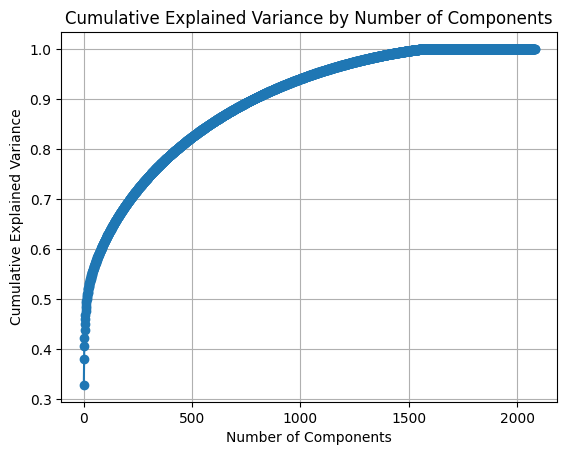

In [9]:
pca = PCA(n_components=2080)  # Use the maximum number of components
pca.fit(sampled_dataset.X[:, :-1])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [14]:
# Create 900 components which make uo 90% of variance
pca = PCA(n_components=900) 
pca.fit(sampled_dataset.X[:, :-1])
print(f"Total explained variance {sum(pca.explained_variance_ratio_)}")

PCA(n_components=900)

In [25]:
# Getting x fits
X_pca_components = pca.fit_transform(sampled_dataset.X[:, :-1])

In [27]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(X_pca_components, sampled_dataset.Y)
dump(regr, 'models/pca_lr.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34255152
Epoch 3, change: 0.17625074
Epoch 4, change: 0.12769611
Epoch 5, change: 0.10144973
Epoch 6, change: 0.08417203
Epoch 7, change: 0.07517677
Epoch 8, change: 0.06884568
Epoch 9, change: 0.06276422
Epoch 10, change: 0.05689206
Epoch 11, change: 0.05199589
Epoch 12, change: 0.04776986
Epoch 13, change: 0.04377262
Epoch 14, change: 0.04058242
Epoch 15, change: 0.03752766
Epoch 16, change: 0.03489047
Epoch 17, change: 0.03260307
Epoch 18, change: 0.03027695
Epoch 19, change: 0.02854892
Epoch 20, change: 0.02666868
Epoch 21, change: 0.02500866
Epoch 22, change: 0.02356838
Epoch 23, change: 0.02234174
Epoch 24, change: 0.02156453
Epoch 25, change: 0.02082496
Epoch 26, change: 0.02016039
Epoch 27, change: 0.01950659
Epoch 28, change: 0.01890791
Epoch 29, change: 0.01832629
Epoch 30, change: 0.01780214
Epoch 31, change: 0.01728779
Epoch 32, change: 0.01682882
Epoch 33, change: 0.01635652
Epoch 34, change: 0.01589763
Epoch 35, change: 0.015

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [13]:
mapper = UMAP().fit(sampled_dataset.X[:, :-1])
transformed_data = mapper.fit_transform(sampled_dataset.X[:, :-1])
umap_features = pd.DataFrame({"UMAP_feature_1": transformed_data[:,0],"UMAP_feature_2":transformed_data[:,1] })
umap_features["labels"] = sampled_dataset.Y

In [14]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=100, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(transformed_data, sampled_dataset.Y)
dump(regr, 'models/umap_lr.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.16071352
Epoch 3, change: 0.07400972
Epoch 4, change: 0.04140902
Epoch 5, change: 0.03266915
Epoch 6, change: 0.02387654
Epoch 7, change: 0.02594926
Epoch 8, change: 0.01899238
Epoch 9, change: 0.01539271
Epoch 10, change: 0.01318598
Epoch 11, change: 0.01247474
Epoch 12, change: 0.01110443
Epoch 13, change: 0.01026686
Epoch 14, change: 0.00932245
Epoch 15, change: 0.00904995
Epoch 16, change: 0.00812338
Epoch 17, change: 0.00746130
Epoch 18, change: 0.00716740
Epoch 19, change: 0.00667510
Epoch 20, change: 0.00631250
Epoch 21, change: 0.00619378
Epoch 22, change: 0.00556794
Epoch 23, change: 0.00530112
Epoch 24, change: 0.00519156
Epoch 25, change: 0.00470720
Epoch 26, change: 0.00462192
Epoch 27, change: 0.00474202
Epoch 28, change: 0.00394944
Epoch 29, change: 0.00408113
Epoch 30, change: 0.00395381
Epoch 31, change: 0.00403691
Epoch 32, change: 0.00363960
Epoch 33, change: 0.00383449
Epoch 34, change: 0.00361678
Epoch 35, change: 0.003

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
get_all_jaccard_index_with_transformation( model=regr, label_encoder=label_encoder,x_transformer=mapper,threshold=0.75)

predicting for patient 0
final_predictions ['stenotrophomonas_maltophilia', 'yersinia_enterocolitica'] , unique ['stenotrophomonas_maltophilia' 'yersinia_enterocolitica']
my predition(s) for patient 0:
['stenotrophomonas_maltophilia', 'yersinia_enterocolitica']
true pathogen
['staphylococcus_aureus']
Jaccard index: 0.0
predicting for patient 1
final_predictions ['burkholderia_pseudomallei'] , unique ['burkholderia_pseudomallei']
my predition(s) for patient 1:
['burkholderia_pseudomallei']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
final_predictions ['burkholderia_pseudomallei', 'neisseria_gonorrhoeae', 'yersinia_enterocolitica'] , unique ['burkholderia_pseudomallei' 'neisseria_gonorrhoeae'
 'yersinia_enterocolitica']
my predition(s) for patient 2:
['burkholderia_pseudomallei', 'neisseria_gonorrhoeae', 'yersinia_enterocolitica']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.25
predicting for patient 3
f

([0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['stenotrophomonas_maltophilia',
  'yersinia_enterocolitica',
  'burkholderia_pseudomallei',
  'burkholderia_pseudomallei',
  'neisseria_gonorrhoeae',
  'yersinia_enterocolitica',
  'burkholderia_pseudomallei',
  'mycobacterium_ulcerans',
  'neisseria_gonorrhoeae',
  'staphylococcus_pseudintermedius',
  'stenotrophomonas_maltophilia',
  'yersinia_enterocolitica',
  'neisseria_gonorrhoeae',
  'pseudomonas_aeruginosa',
  'stenotrophomonas_maltophilia',
  'campylobacter_jejuni',
  'yersinia_enterocolitica',
  'burkholderia_pseudomallei',
  'campylobacter_jejuni',
  'burkholderia_pseudomallei',
  'campylobacter_jejuni',
  'neisseria_gonorrhoeae',
  'staphylococcus_pseudintermedius',
  'burkholderia_pseudomallei',
  'campylobacter_jejuni',
  'neisseria_gonorrhoeae',
  'stenotrophomonas_maltophilia',
  'yersinia_enterocolitica',
  'campylobacter_jejuni',
  'neisseria_gonorrhoeae'],
 ['staphylococcus_aureus',
  'staphylococcus_pyogenes',


In [12]:
import plotly.express as px

fig = px.histogram(umap_features, x="UMAP_feature_1", color="labels")
fig.show()

fig = px.histogram(umap_features, x="UMAP_feature_2", color="labels")
fig.show()


The data and labels are then accessible via `sampled_dataset.X` and `sampled_dataset.Y`.

In [11]:
from sklearn.model_selection import train_test_split
# Having a training/validation set
X_train, X_test, y_train, y_test = train_test_split(sampled_dataset.X, sampled_dataset.Y,
                                                    stratify=sampled_dataset.Y, 
                                                    test_size=0.25)

In [12]:
# Using a smaller lightweight model
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_train, y_train)

dump(clf, 'models/nb_model.joblib')

['models/nb_model.joblib']

In [15]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(X_train, y_train)
dump(regr, 'models/log_reg.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28101461
Epoch 3, change: 0.20038747
Epoch 4, change: 0.15242559
Epoch 5, change: 0.12505654
Epoch 6, change: 0.10573650
Epoch 7, change: 0.09499900
Epoch 8, change: 0.08598759
Epoch 9, change: 0.07898506
Epoch 10, change: 0.07285994
Epoch 11, change: 0.06688776
Epoch 12, change: 0.06172971
Epoch 13, change: 0.05686876
Epoch 14, change: 0.05233452
Epoch 15, change: 0.04802390
Epoch 16, change: 0.04477193
Epoch 17, change: 0.04161416
Epoch 18, change: 0.03887196
Epoch 19, change: 0.03642944
Epoch 20, change: 0.03420195
max_iter reached after 63 seconds
Time taken : 62.572902916000004


/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=regr, label_encoder=label_encoder)

predicting for patient 0
my predition(s) for patient 0:
[]
true pathogen
['staphylococcus_aureus']
Jaccard index: 0.0
predicting for patient 1
my predition(s) for patient 1:
[]
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
my predition(s) for patient 2:
['burkholderia_pseudomallei']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.5
predicting for patient 3
my predition(s) for patient 3:
[]
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.0
predicting for patient 4
my predition(s) for patient 4:
[]
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 0.0
predicting for patient 5
my predition(s) for patient 5:
[]
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 6
my predition(s) for patient 6:
[]
true pathogen
['mycobacterium_ulcerans']
Jaccard index: 0.0
predicting for patient 7
my predition(s) for patient 7:
['clostridioides_difficile']
true pathogen
['my

 Macro Precision :  0.83, Recall :  0.80, F1 :  0.80
 Micro Precision :  0.80, Recall :  0.80, F1 :  0.80


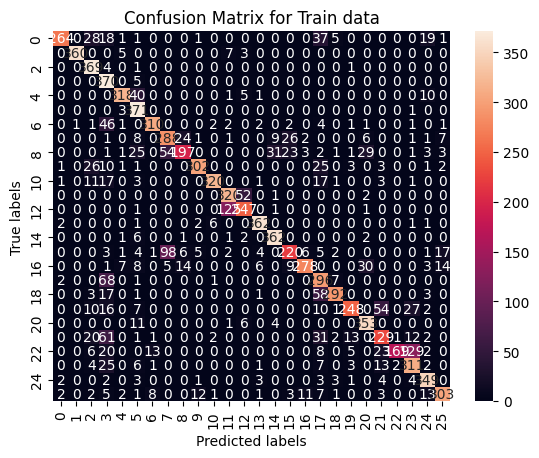

 Macro Precision :  0.82, Recall :  0.79, F1 :  0.79
 Micro Precision :  0.79, Recall :  0.79, F1 :  0.79


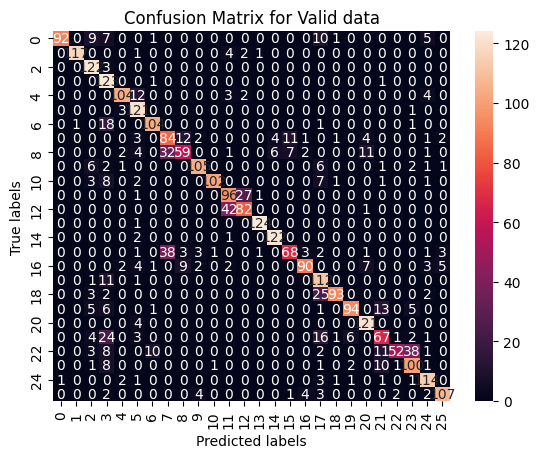

In [16]:

performance_evaluate(
    train_dataset=(X_train, y_train),
    valid_dataset=(X_test,y_test),
    model_name="log_reg",
    filepath="models"
)

In [41]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(sampled_dataset.X, sampled_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 6, change: 0.11266158
Epoch 1, change: 1.00000000
Epoch 7, change: 0.09846733
Epoch 2, change: 0.36959501
Epoch 3, change: 0.22549589
Epoch 8, change: 0.08723684
Epoch 4, change: 0.16383981
Epoch 9, change: 0.07821385
Epoch 5, change: 0.13149948
Epoch 10, change: 0.07094194
Epoch 6, change: 0.11140447
Epoch 11, change: 0.06377122
Epoch 7, change: 0.09730791
Epoch 12, change: 0.05783596
Epoch 8, change: 0.08619516
Epoch 13, change: 0.05263313
Epoch 9, change: 0.07755324
Epoch 14, change: 0.04830091
Epoch 10, change: 0.07021079
Epoch 15, change: 0.04427609
Epoch 11, change: 0.06334869
Epoch 16, change: 0.04116502
Epoch 12, change: 0.05726081
Epoch 17, change: 0.03808542
Epoch 13, change: 0.05218956
Epoch 18, change: 0.03529336
Epoch 14, change: 0.04784638
Epoch 19, change: 0.03318797
Epoch 15, change: 0.04393941
Epoch 20, change: 0.03107522
Epoch 16, change: 0.04067527
Epoch 21, change: 0.02917567
Epoch 17, change: 0.03796250
Epoch 22, change: 0.02749146
Epoch 18, change: 0.0352185

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


We can now save our trained model for later usage. This is an example of how you can send your model to our final evaluation.

In [ ]:
from joblib import dump, load
dump(regr, 'models/baseline.joblib')

### Trying out the GridSearchCV method he suggested but takes even longer and coef_ did not coverge as max_iter of 500 is reached

In [42]:
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 2, change: 0.78394006
Epoch 2, change: 0.23476796
Epoch 2, change: 0.92647704
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


KeyboardInterrupt: 

Epoch 56, change: 0.00896325
Epoch 57, change: 0.00874027


In [ ]:
np.random.random()

Then the model can be loaded using

```python
# load trained model
regr = load('models/baseline.joblib')
```

## Evaluation of Model

Now that you have your trained model, you can use it on each of the patient's read dataset and try to find the pathogens that appear in each patient.

Your model is evaluated based on [**Jaccard index**](https://en.wikipedia.org/wiki/Jaccard_index#Jaccard_index_in_binary_classification_confusion_matrices). For patient $i$, let $P$ be the set of pathogen species your model predicted (or $\{\text{decoy}\}$ if there is no pathogens predicted), and $T$ the set of pathogen species the patient actually have (or $\{\text{decoy}\}$ if there is no pathogens in the reads), the score for your model is

$$\text{Jaccard index}=\frac{|P\cap T|}{|P \cup T|}$$

Going back to our model: since we are using logistic regression, our model will classify each read to the class that has the highest probability of having the read. If we report all the species that a read has been classified to, then we may end up with a lot of false positives (why?).

One potential way to counter this is to define a threshold. Here I used 0.95: I only report a species if I am 95% confident that one read comes from that species. Let's see how well my model will behave...

In [28]:
baseline_model =_read_model(filepath="models", model_name="baseline")
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=baseline_model, label_encoder=label_encoder,threshold=0.9)

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


predicting for patient 0
my predition(s) for patient 0:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 1.0
predicting for patient 1
my predition(s) for patient 1:
['listeria_monocytogenes', 'neisseria_gonorrhoeae', 'staphylococcus_pyogenes']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.3333333333333333
predicting for patient 2
my predition(s) for patient 2:
['burkholderia_pseudomallei', 'clostridioides_difficile', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.6666666666666666
predicting for patient 3
my predition(s) for patient 3:
['clostridioides_difficile', 'pseudomonas_aeruginosa', 'staphylococcus_pseudintermedius', 'yersinia_enterocolitica']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.25
predicting for patient 4
my predition(s) for patient 4:
['corynebacterium_diphtheriae', 'listeria_monocytogenes', 'staphylococcus_aureus', 'staphylococcus_pseudinterme

In [30]:
print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

['patient 0: 1.0', 'patient 1: 0.3333333333333333', 'patient 2: 0.6666666666666666', 'patient 3: 0.25', 'patient 4: 0.2', 'patient 5: 0.3333333333333333', 'patient 6: 0.25', 'patient 7: 0.16666666666666666', 'patient 8: 0.25', 'patient 9: 0.25'] avg: 0.37


In [12]:
set(all_true)

{'burkholderia_pseudomallei',
 'corynebacterium_diphtheriae',
 'corynebacterium_ulcerans',
 'mycobacterium_tuberculosis',
 'mycobacterium_ulcerans',
 'pseudomonas_aeruginosa',
 'staphylococcus_aureus',
 'staphylococcus_pyogenes',
 'streptococcus_pneumoniae'}

In [10]:
set(all_pred)

{'burkholderia_pseudomallei',
 'clostridioides_difficile',
 'corynebacterium_ulcerans',
 'listeria_monocytogenes',
 'neisseria_gonorrhoeae',
 'pseudomonas_aeruginosa',
 'staphylococcus_aureus',
 'staphylococcus_pseudintermedius',
 'streptococcus_pneumoniae',
 'yersinia_enterocolitica'}

So the overall score for my model is 0.45. Not a bad start, but still much room for improvement. You don't necessarily need to work on this baseline; this was just released as an example. Have fun!!!